In [1]:
import os
import json
import numpy as np
import cv2
import rasterio
from rasterio.windows import Window
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from matplotlib import pyplot as plt
from tqdm import tqdm


In [2]:
DATA_DIR = r"/content"

tiff_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.lower().endswith(".tif")]
json_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.lower().endswith(".json")]

print("TIFF files:", tiff_files)
print("JSON files:", json_files)


TIFF files: ['/content/GC01PS03D0123.tif', '/content/GC01PS03D0011.tif', '/content/GC01PS03D0155.tif']
JSON files: ['/content/GC01PS03D0123.json', '/content/GC01PS03D0155.json', '/content/GC01PS03D0011.json']


In [3]:
def scale_to_uint8(img):
    img = img.astype(np.float32)
    img -= img.min()
    if img.max() > 0:
        img /= img.max()
    return (img * 255).astype(np.uint8)

def load_tiff_rgb_preview(path, max_size=1024):
    ds = rasterio.open(path)
    H, W = ds.height, ds.width

    scale = min(max_size / H, max_size / W)
    new_h = int(H * scale)
    new_w = int(W * scale)

    img = ds.read([3,2,1], out_shape=(3, new_h, new_w))  # only RGB bands
    img = np.transpose(img, (1,2,0))
    img = scale_to_uint8(img)

    return img, scale, (H, W)

def scale_bbox(bbox, scale):
    x1, y1, x2, y2 = bbox
    return [int(x1 * scale), int(y1 * scale), int(x2 * scale), int(y2 * scale)]

def load_annotations(json_file):
    with open(json_file) as f:
        data = json.load(f)

    boxes = []
    cls = None

    for feat in data["features"]:
        coords = feat["geometry"]["coordinates"][0][0]
        xs = [c[0] for c in coords]
        ys = [c[1] for c in coords]

        bbox = [min(xs), min(ys), max(xs), max(ys)]
        cls = feat["properties"]["Class Name"]
        boxes.append({"bbox": bbox, "class": cls})

    return boxes, cls

def extract_chip(image, bbox, pad=0):
    x1, y1, x2, y2 = bbox
    return image[y1-pad:y2+pad, x1-pad:x2+pad]



In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize((224,224)),
        ])

    def forward(self, img):
        img = self.transform(img).unsqueeze(0)
        with torch.no_grad():
            feat = self.backbone(img).flatten()
        return feat

model = FeatureExtractor().eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


In [5]:
def compute_chip_embedding(chip, model):
    chip_scaled = scale_to_uint8(chip[:, :, :3])
    chip_rgb = chip_scaled[:, :, ::-1].copy()   # BGR → RGB
    return model(chip_rgb)


In [6]:
def sliding_window_search(image, sample_feat, win_size=128, stride=64, threshold=0.7):
    H, W, _ = image.shape
    detections = []

    for y in range(0, H - win_size, stride):
        for x in range(0, W - win_size, stride):

            patch = image[y:y+win_size, x:x+win_size]

            patch_scaled = scale_to_uint8(patch[:, :, :3])
            patch_rgb = patch_scaled[:, :, ::-1].copy()

            patch_feat = model(patch_rgb)
            sim = torch.cosine_similarity(sample_feat, patch_feat, dim=0).item()

            if sim >= threshold:
                detections.append([x, y, x+win_size, y+win_size, sim])

    return detections


In [7]:
def sliding_window_from_tiff(path, sample_feat,
                             tile_size=1024, win_size=128, stride=64, threshold=0.7):

    ds = rasterio.open(path)
    H, W = ds.height, ds.width
    detections = []

    for y0 in tqdm(range(0, H, tile_size), desc="Processing Rows"):
        for x0 in range(0, W, tile_size):

            tile_h = min(tile_size, H - y0)
            tile_w = min(tile_size, W - x0)

            tile = ds.read([3,2,1], window=Window(x0, y0, tile_w, tile_h))
            tile = np.transpose(tile, (1,2,0))
            tile = scale_to_uint8(tile)

            dets = sliding_window_search(tile, sample_feat, win_size, stride, threshold)

            for d in dets:
                d[0] += x0
                d[1] += y0
                d[2] += x0
                d[3] += y0
                detections.append(d)

    return detections


In [8]:
def plot_detections(image, detections):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    for x1, y1, x2, y2, s in detections:
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,
                             edgecolor='red', fill=False, linewidth=2)
        plt.gca().add_patch(rect)
    plt.show()


In [9]:
def save_results(dets, outfile, classname, imgname):
    with open(outfile, "w") as f:
        for x1, y1, x2, y2, s in dets:
            f.write(f"{x1} {y1} {x2} {y2} {classname} {imgname} {s:.4f}\n")


In [10]:
json_path = json_files[0]
boxes, cls = load_annotations(json_path)

tif_path = json_path.replace(".json", ".tif")

preview_img, scale, (H, W) = load_tiff_rgb_preview(tif_path)

scaled_bbox = scale_bbox(boxes[0]["bbox"], scale)

sample_chip = extract_chip(preview_img, scaled_bbox)
sample_feat = compute_chip_embedding(sample_chip, model)

detections = sliding_window_from_tiff(
    tif_path, sample_feat,
    tile_size=1024, win_size=128, stride=64, threshold=0.7
)

save_results(detections, "tiff_results.txt", cls, os.path.basename(tif_path))


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing Rows: 100%|██████████| 2/2 [00:34<00:00, 17.05s/it]


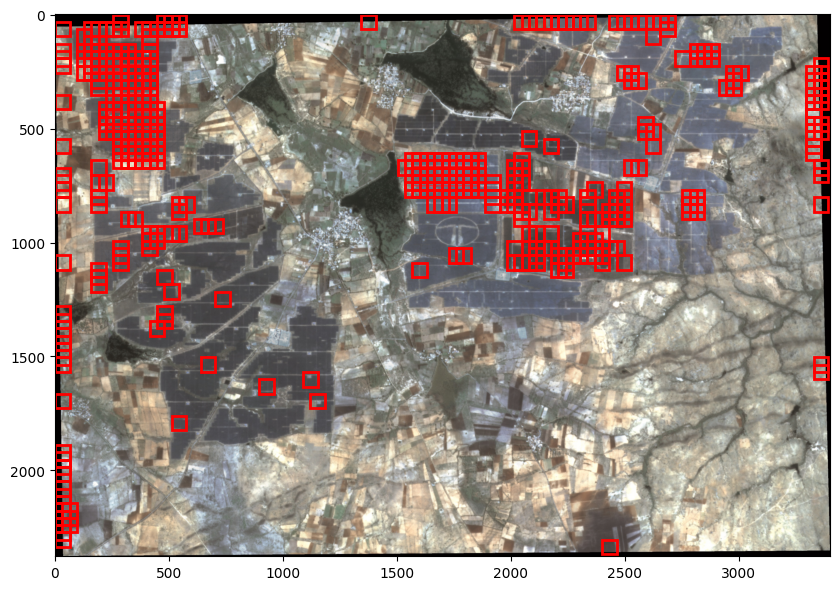

In [11]:
query_chip = cv2.imread(os.path.join(DATA_DIR, "obj_1.jpg"))
query_chip = cv2.cvtColor(query_chip, cv2.COLOR_BGR2RGB)
query_feat = compute_chip_embedding(query_chip, model)

search_img = cv2.imread(os.path.join(DATA_DIR, "annotated.jpg"))
search_img = cv2.cvtColor(search_img, cv2.COLOR_BGR2RGB)
search_img = scale_to_uint8(search_img)

custom_dets = sliding_window_search(search_img, query_feat, win_size=64, stride=32, threshold=0.7)

plot_detections(search_img, custom_dets)

save_results(custom_dets, "custom_results.txt", "CustomObject", "annotated.jpg")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')